# DSCI 100 Group 152 Project Report

## Advertisement Detection Using KNN Classification

### Group 152: Marie Samantha Fidelia, Rafi Arnouk, Ki’an Merali, Vivaan Jhaveri

## Introduction:
In recent years, the booming of online advertising has proved to be a highly effective tool to attract new customers for businesses, collect useful information about target audiences, diversify revenue streams and much more. It provides full marketing control in an efficient manner and at a low cost. Consequently, advertisements can be found on virtually every internet page. The purpose of our report is to use KNN classification to train a dataset and use the model to help us predict whether an image on an internet page is an advertisement or not.

### The goal of our project is to answer the following question:

Can we predict whether an image on an internet page is an advertisement or not using KNN classification?
What will the accuracy of our model be, and what can be done to improve it?
Can our model be implemented to real-life scenarios, and what would be the impact of it?
To get started with our project, we will apply our classification model to a dataset that was obtained from: https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements

Credits to Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
The dataset is downloaded in a comma separated format. It contains 3 continuous variables (height, width, and ratio), as well as 1554 binary values (0 means no, 1 means yes) regarding the aspects of the image, which was then summed up into one new column called the "Attributes". The aspects of the image includes 19 caption features, 111 alt features, 495 base URL features, 472 destination URL features, and 457 in-image URL features. Several missing values are interpreted as a question mark ("?") in the dataset.

##### Methods & Results:
- Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- Your report should include code which:
1) Loads data from the original source on the web 
2) Wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
3) Performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
4) Creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
5) Performs the data analysis
6) Creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend
##### Discussion:
- Summarize what you found
- Discuss whether this is what you expected to find?
- Discuss what impact could such findings have?
- Discuss what future questions could this lead to?
##### References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

## Preliminary exploratory data analysis:
### Reading Our Dataset
We start by importing the necessary libraries for our modelling

In [2]:
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Our dataset contains too many rows and columns that will take a long time to read. 
Hence, we will only take the first 1000 rows of the dataset into account, and display the necessary columns.

In [3]:
# Read csv data without column name into R 
import_ad_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vT-EQ-KjxjC37NSyio0pmiKB537CB7HP_990fSVeg2BXJGow75PWNEbwRgiyDzkFeWPxH_XC4Hg13fb/pub?gid=1972417586&single=true&output=csv",
                           col_names = FALSE, col_select = c("X1", "X2", "X3", "X1560", "X1559"), n_max = 1000)

# Rename column names and filter out missing values
ad_data <- rename(import_ad_data, Height = X1, Width = X2, Ratio = X3, Attributes = X1560, Type = X1559)

glimpse(ad_data) 

Rows: 1000 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): X1, X2, X3, X1559
dbl (1): X1560

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,000
Columns: 5
$ Height     <chr> "125", "57", "33", "60", "60", "60", "59", "60", "60", "60"…
$ Width      <chr> "125", "468", "230", "468", "468", "468", "460", "234", "46…
$ Ratio      <chr> "1", "8.2105", "6.9696", "7.8", "7.8", "7.8", "7.7966", "3.…
$ Attributes <dbl> 14, 11, 22, 26, 24, 24, 27, 31, 23, 24, 32, 34, 33, 30, 22,…
$ Type       <chr> "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad…


### Cleaning and Wrangling Data Into Tidy Format
Let's filter out the missing values contained as "?" in each cell.

In [4]:
ad_filtered <- filter(ad_data, Height != "?" , Width != "?" , Ratio != "?")

In [5]:
ad_missing <- filter(ad_data, Height == "?" | Width == "?" | Ratio == "?") |>
              summarize(n = n())
ad_missing

n
<int>
244


The tibble above shows that 244 rows are removed for having missing values.

Next, set the two distinct image types as a factor, and convert the columns from character to numeric.

In [6]:
ad_factored <- ad_filtered |>
               mutate(Height = as.numeric(Height),
                      Width = as.numeric(Width),
                      Ratio = as.numeric(Ratio),
                      Type = as_factor(Type))
ad_factored

Height,Width,Ratio,Attributes,Type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
125,125,1.0000,14,ad.
57,468,8.2105,11,ad.
33,230,6.9696,22,ad.
60,468,7.8000,26,ad.
60,468,7.8000,24,ad.
60,468,7.8000,24,ad.
59,460,7.7966,27,ad.
60,234,3.9000,31,ad.
60,468,7.8000,23,ad.


## Visualising the data:

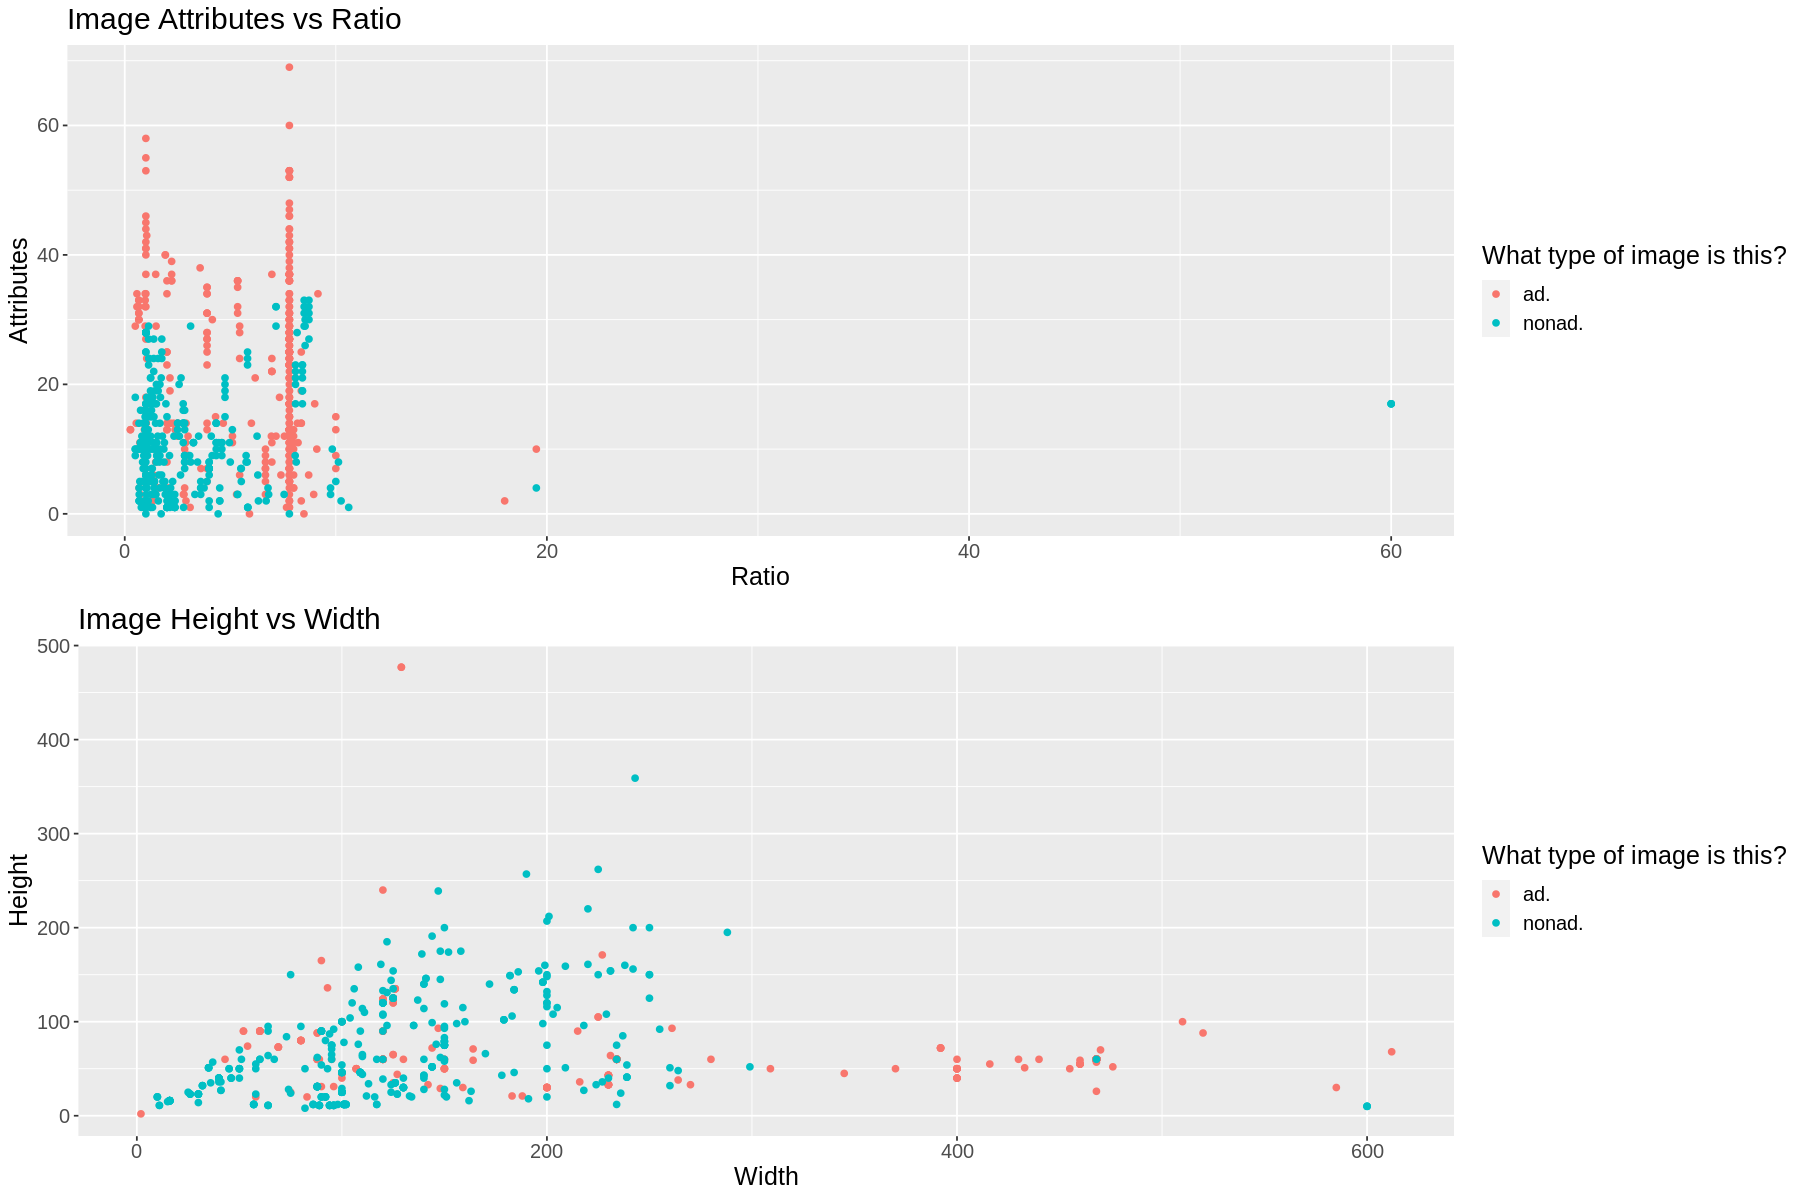

In [7]:
# Plot to see the relationship between image ratio and attributes to type

options(repr.plot.width = 15, repr.plot.height = 10)
ad_plot_ar  <- ad_factored |>
               ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
               geom_point()  + 
               xlab("Ratio") + 
               ylab("Attributes") +
               labs(colour = "What type of image is this?") +
               ggtitle("Image Attributes vs Ratio")+
               theme(text = element_text(size=15)) 

# Plot to see the relationship between image width and height to type

options(repr.plot.width = 15, repr.plot.height = 10)
ad_plot_hw  <- ad_factored |>
               ggplot(aes(x = Width, y = Height, color = Type)) + 
               geom_point()  + 
               xlab("Width") + 
               ylab("Height") +
               labs(colour = "What type of image is this?") + 
               ggtitle("Image Height vs Width")+
               theme(text = element_text(size=15)) 

plot_grid(ad_plot_ar, ad_plot_hw, ncol = 1)

We can see that there are outliers from our data. Let's remove them to prevent any performance errors in the future.

In [8]:
summary(ad_factored)
# IQR = Q3 - Q1
# MIN = Q1 - 1.5 IQR
# MAX = Q3 + 1.5 IQR

     Height           Width           Ratio           Attributes   
 Min.   :  2.00   Min.   :  2.0   Min.   : 0.2704   Min.   : 0.00  
 1st Qu.: 40.00   1st Qu.:100.0   1st Qu.: 1.2145   1st Qu.: 7.00  
 Median : 60.00   Median :150.0   Median : 3.5357   Median :13.00  
 Mean   : 66.77   Mean   :225.1   Mean   : 4.5083   Mean   :16.26  
 3rd Qu.: 79.00   3rd Qu.:468.0   3rd Qu.: 7.8000   3rd Qu.:25.00  
 Max.   :477.00   Max.   :612.0   Max.   :60.0000   Max.   :69.00  
     Type    
 ad.   :386  
 nonad.:370  
             
             
             
             

We can identify the outliers using quartile range formula, and remove the outliers from each predictors above.

In [9]:
ad_cleaned <- filter(ad_factored, 
                     Height >= -18.5, 
                     Height <= 137.5,
                     Width >= -452,
                     Width <= 1020,
                     Ratio >= -8.66375,
                     Ratio <= 17.67825,
                     Attributes >= -27,
                     Attributes <= 52)
ad_cleaned

Height,Width,Ratio,Attributes,Type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
125,125,1.0000,14,ad.
57,468,8.2105,11,ad.
33,230,6.9696,22,ad.
60,468,7.8000,26,ad.
60,468,7.8000,24,ad.
60,468,7.8000,24,ad.
59,460,7.7966,27,ad.
60,234,3.9000,31,ad.
60,468,7.8000,23,ad.


After removing the outliers, let's check what our new data is composed of!

In [10]:
new_proportions_train <- ad_cleaned |>
                         group_by(Type) |>
                         summarize(n = n())
                        
new_proportions_train

Type,n
<fct>,<int>
ad.,370
nonad.,319


The table above showed that 67 outlier values were removed from our data.

Now that we have removed the outliers, let's plot the new data!

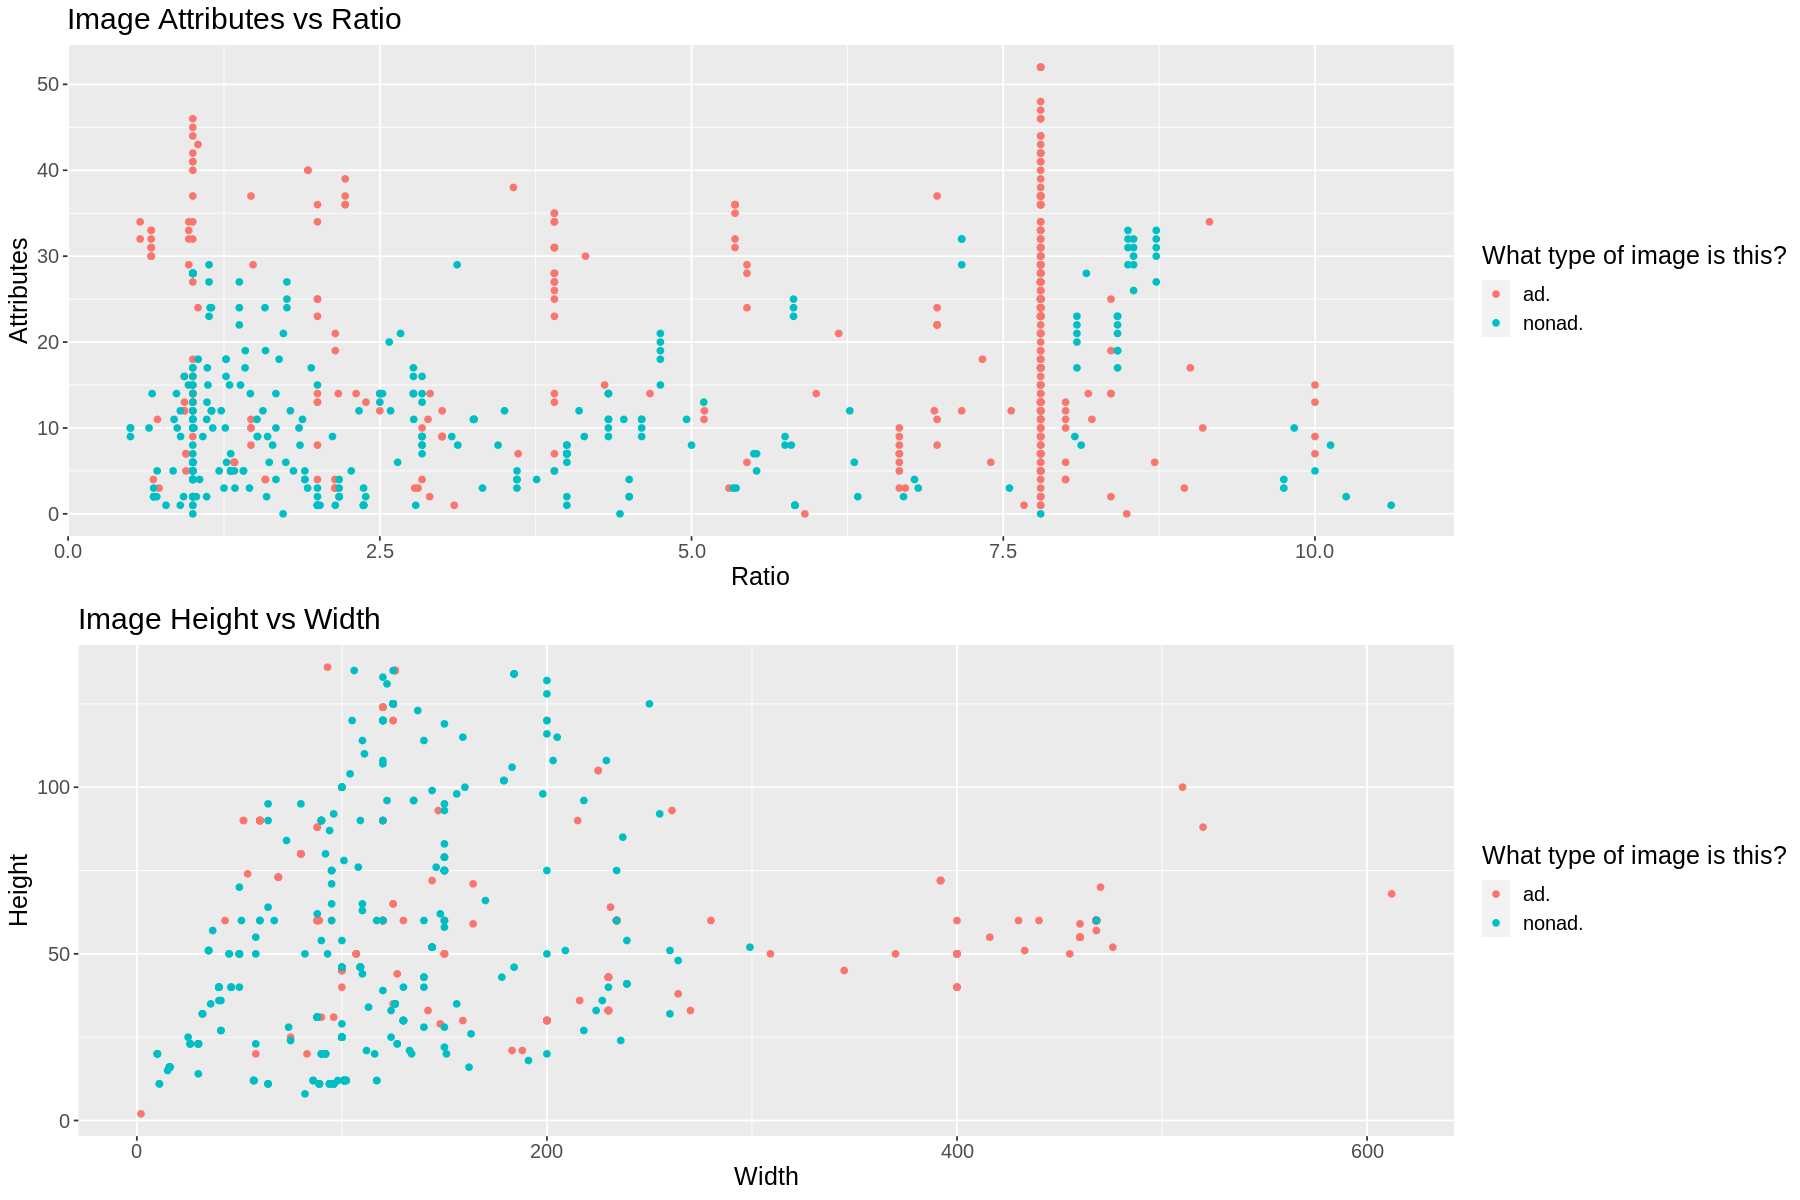

In [11]:
# Plot the new relationship between image ratio and attributes to type

options(repr.plot.width = 15, repr.plot.height = 10)
new_plot_ar <- ad_cleaned |>
               ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
               geom_point()  + 
               xlab("Ratio") + 
               ylab("Attributes") +
               labs(colour = "What type of image is this?") +
               ggtitle("Image Attributes vs Ratio")+
               theme(text = element_text(size=15)) 

# Plot the new relationship between image width and height to type

options(repr.plot.width = 15, repr.plot.height = 10)
new_plot_hw <- ad_cleaned |>
               ggplot(aes(x = Width, y = Height, color = Type)) + 
               geom_point()  + 
               xlab("Width") + 
               ylab("Height") +
               labs(colour = "What type of image is this?") + 
               ggtitle("Image Height vs Width")+
               theme(text = element_text(size=15)) 

plot_grid(new_plot_ar, new_plot_hw, ncol = 1)

From the plot above, we can see that 'ad' types tend to have more attributes than 'nonad' images, and most are clustered in the ratio of 7.7. In addition, images with large widths are more likely to classify as an 'ad'.

## Forward Analysis for Predictor Variable Selection

To decide which predictors to use to optimize the performance of our model, we can use forward analysis.

In [12]:
set.seed(123)

# possible predictor names
names <- colnames(ad_cleaned |> select(-Type))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
ad_fa_vfold <- vfold_cv(ad_cleaned, v = 5, strata = Type)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Type", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        ad_fa_recipe <- recipe(as.formula(model_string), 
                                data = ad_cleaned) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(ad_fa_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = ad_fa_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Type ~ Height,0.8098805
2,Type ~ Height+Ratio,0.8940654
3,Type ~ Height+Ratio+Attributes,0.9144081
4,Type ~ Height+Ratio+Attributes+Width,0.9100603


It looks like using three predictors, omitting width, optimizes the accuracy of our model. With height, ratio, and attributes alone, our accuracy was 91.4%, and it decreased to 91.0% with the inclusion of width. This analysis also tells us the effectiveness of each predictor. We can see that the height variable has the strongest correlation to our classifier variable, followed by ratio, attributes, and width.

## Training our Model
Now we can split our data into training and test set. Our training set will contain 85.6% of the original data, so that the test set will consist of 100 observation rows.

In [13]:
set.seed(1) # Set the seed to a value of 1

ad_split <- initial_split(ad_cleaned, prop = 0.856, strata = Type)
ad_train <- training(ad_split)
ad_test <- testing(ad_split) 

glimpse(ad_train)
glimpse(ad_test)

Rows: 589
Columns: 5
$ Height     <dbl> 125, 57, 33, 60, 60, 60, 90, 90, 90, 33, 60, 60, 125, 90, 9…
$ Width      <dbl> 125, 468, 230, 468, 468, 468, 52, 60, 60, 230, 468, 468, 12…
$ Ratio      <dbl> 1.0000, 8.2105, 6.9696, 7.8000, 7.8000, 7.8000, 0.5777, 0.6…
$ Attributes <dbl> 14, 11, 22, 26, 24, 23, 34, 33, 30, 22, 28, 48, 27, 32, 31,…
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…
Rows: 100
Columns: 5
$ Height     <dbl> 60, 59, 60, 60, 60, 90, 60, 60, 60, 60, 65, 125, 60, 60, 80…
$ Width      <dbl> 468, 460, 234, 468, 468, 60, 468, 120, 468, 468, 125, 125, …
$ Ratio      <dbl> 7.8000, 7.7966, 3.9000, 7.8000, 7.8000, 0.6666, 7.8000, 2.0…
$ Attributes <dbl> 24, 27, 31, 24, 27, 31, 25, 23, 41, 25, 40, 40, 25, 31, 13,…
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…


In [14]:
data_proportions_train <- ad_train |>
                          group_by(Type) |>
                          summarize(n = n()) |>
                          mutate(percent = 100*n/nrow(ad_train))
data_proportions_train

data_proportions_test <- ad_test |>
                         group_by(Type) |>
                         summarize(n = n()) |>
                         mutate(percent = 100*n/nrow(ad_test))
data_proportions_test

Type,n,percent
<fct>,<int>,<dbl>
ad.,316,53.65025
nonad.,273,46.34975


Type,n,percent
<fct>,<int>,<dbl>
ad.,54,54
nonad.,46,46


It looks like both the training and test set have a quite balanced proportion between 'ad' and 'nonad' types!

Now let's see how our training data compares the distributions of each of the predictor variables!

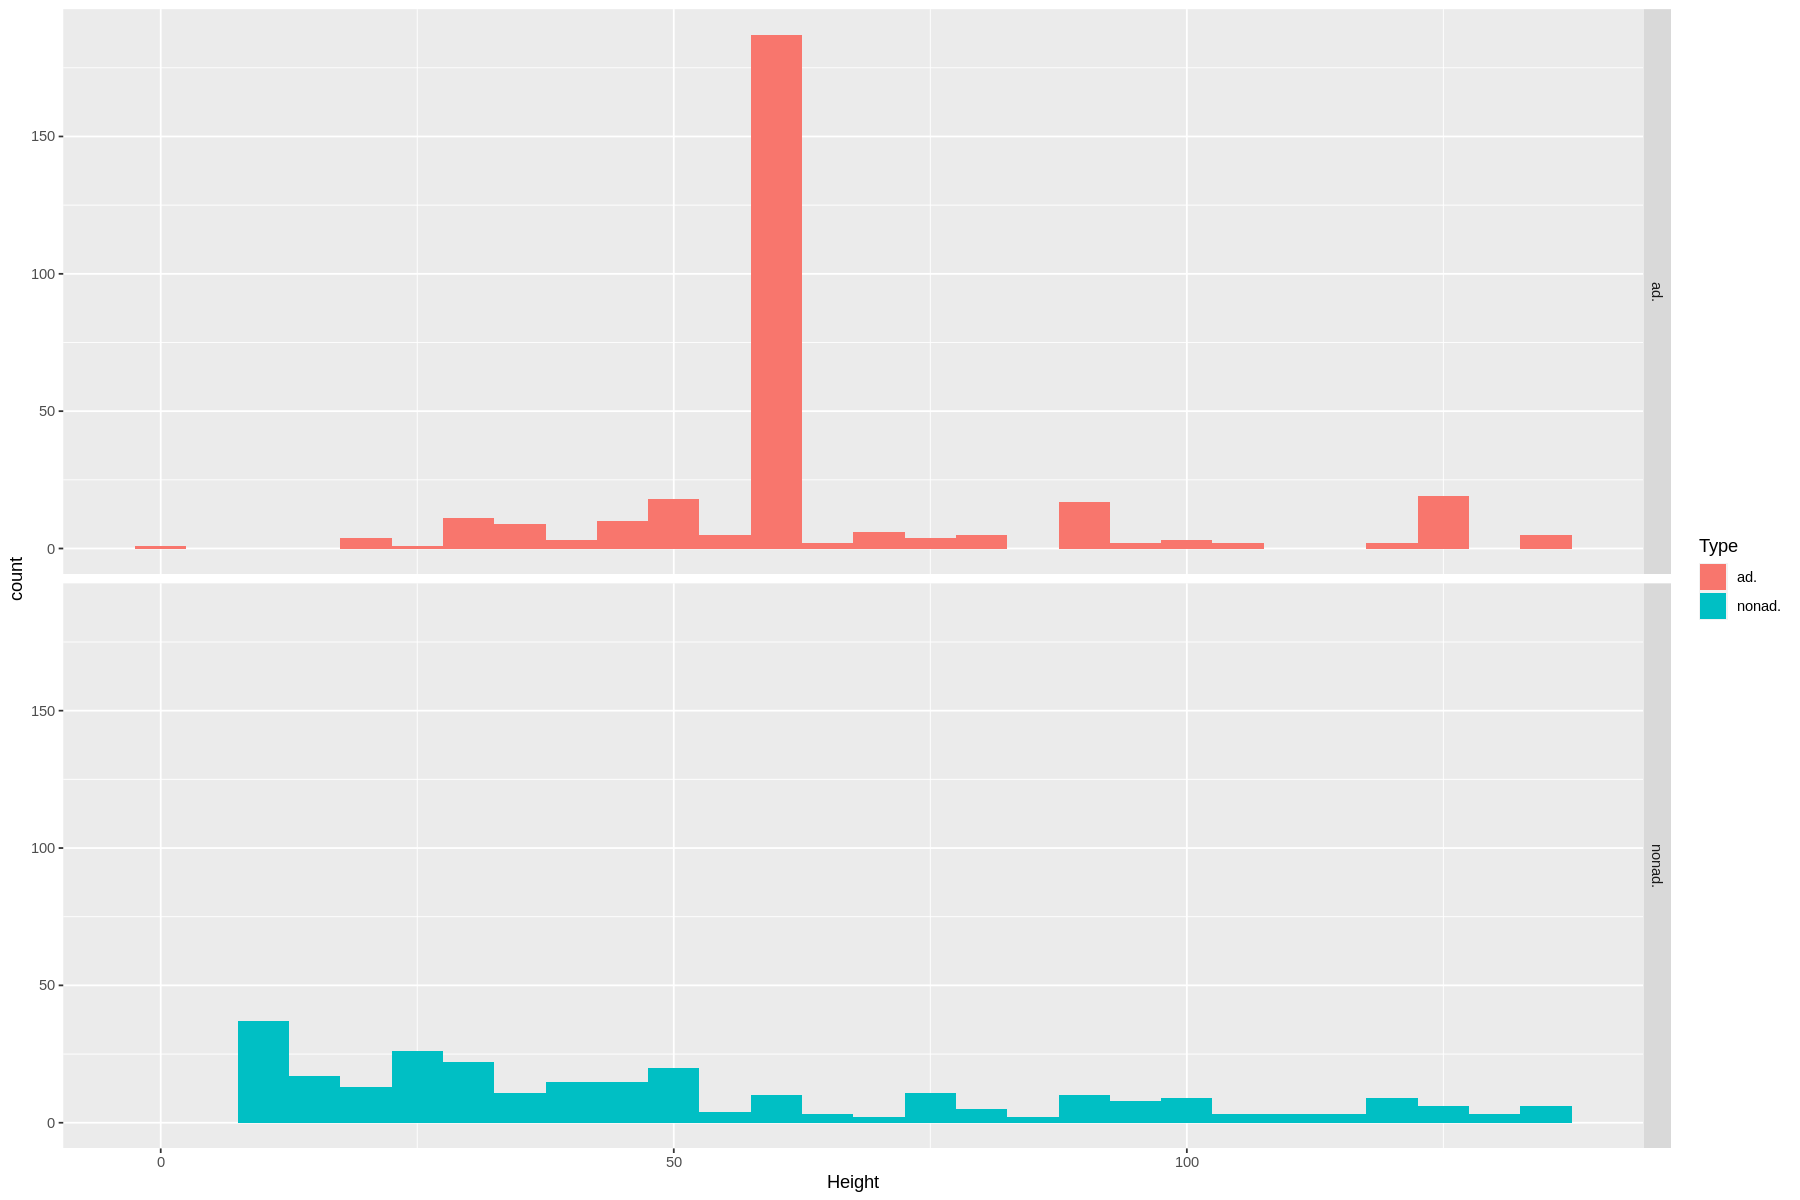

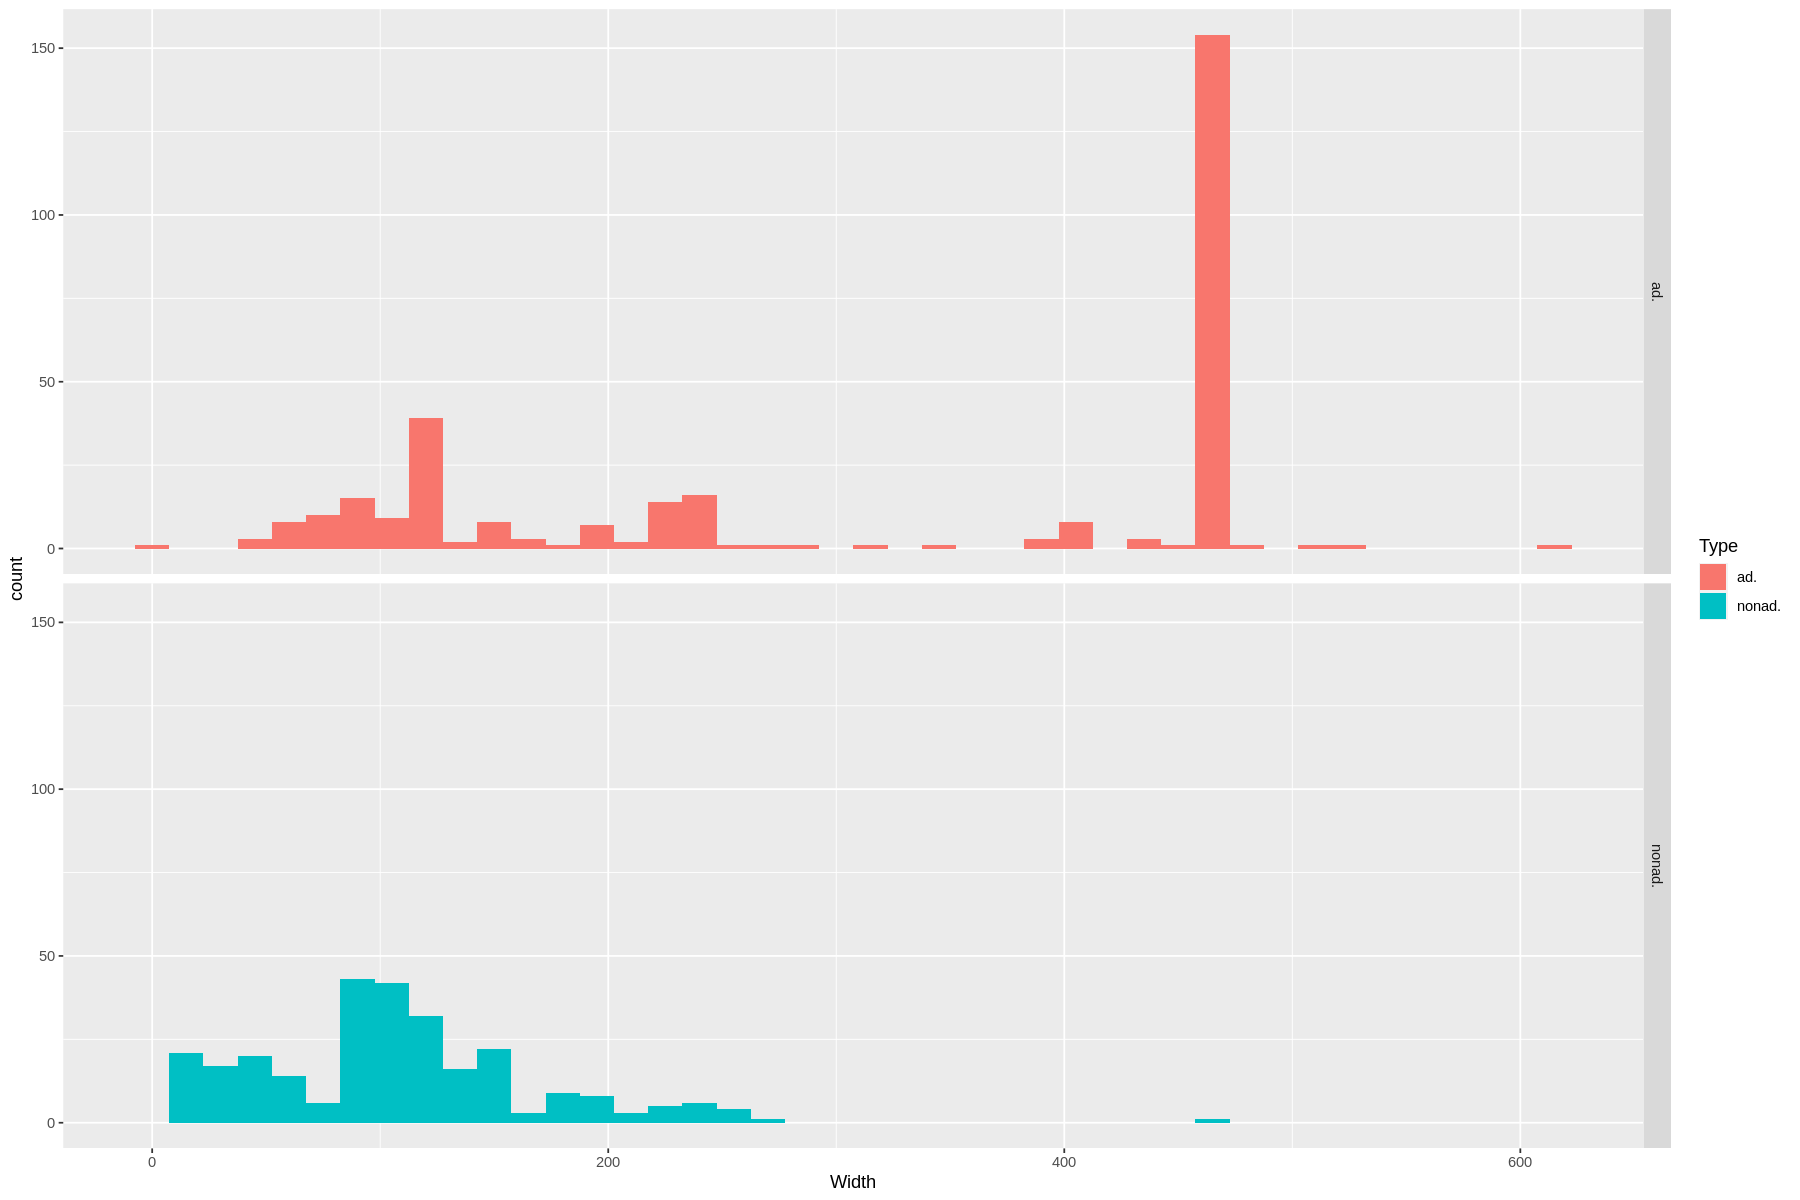

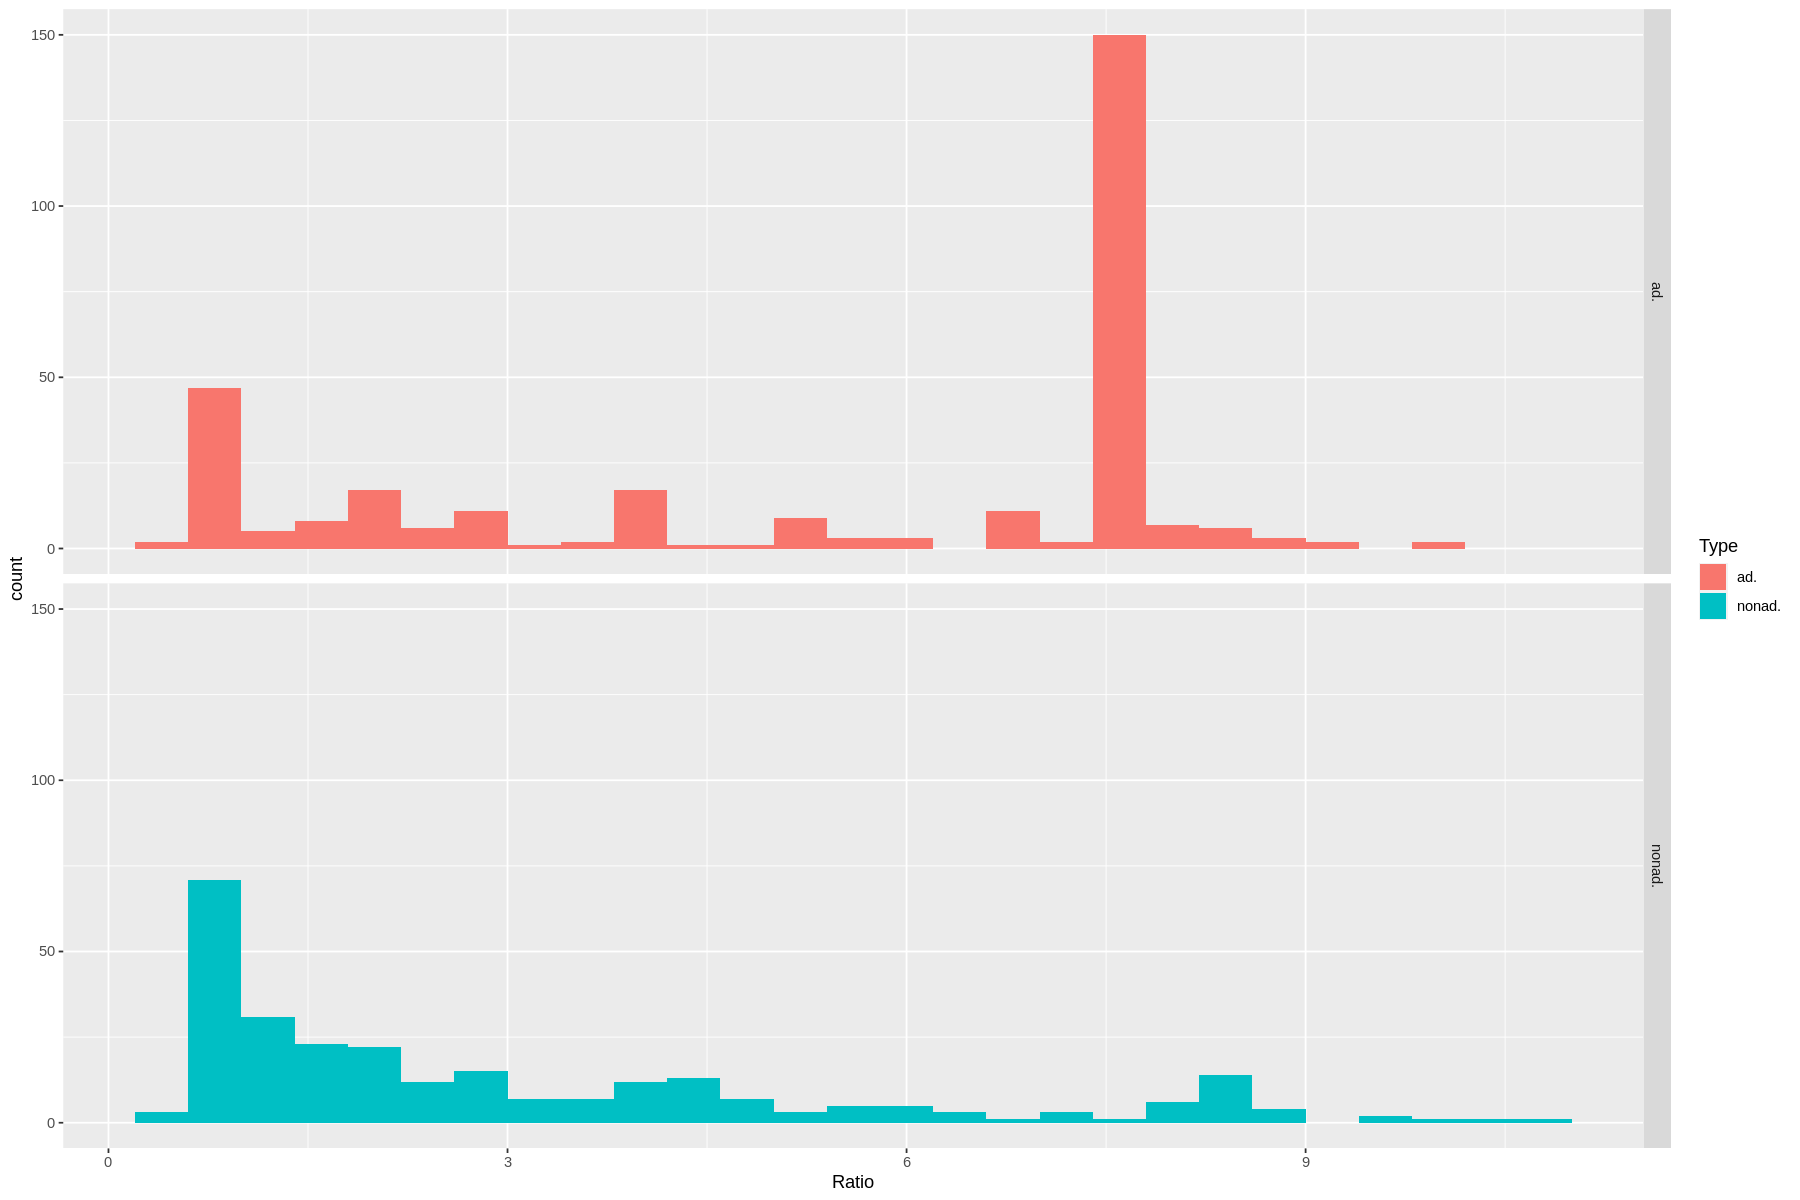

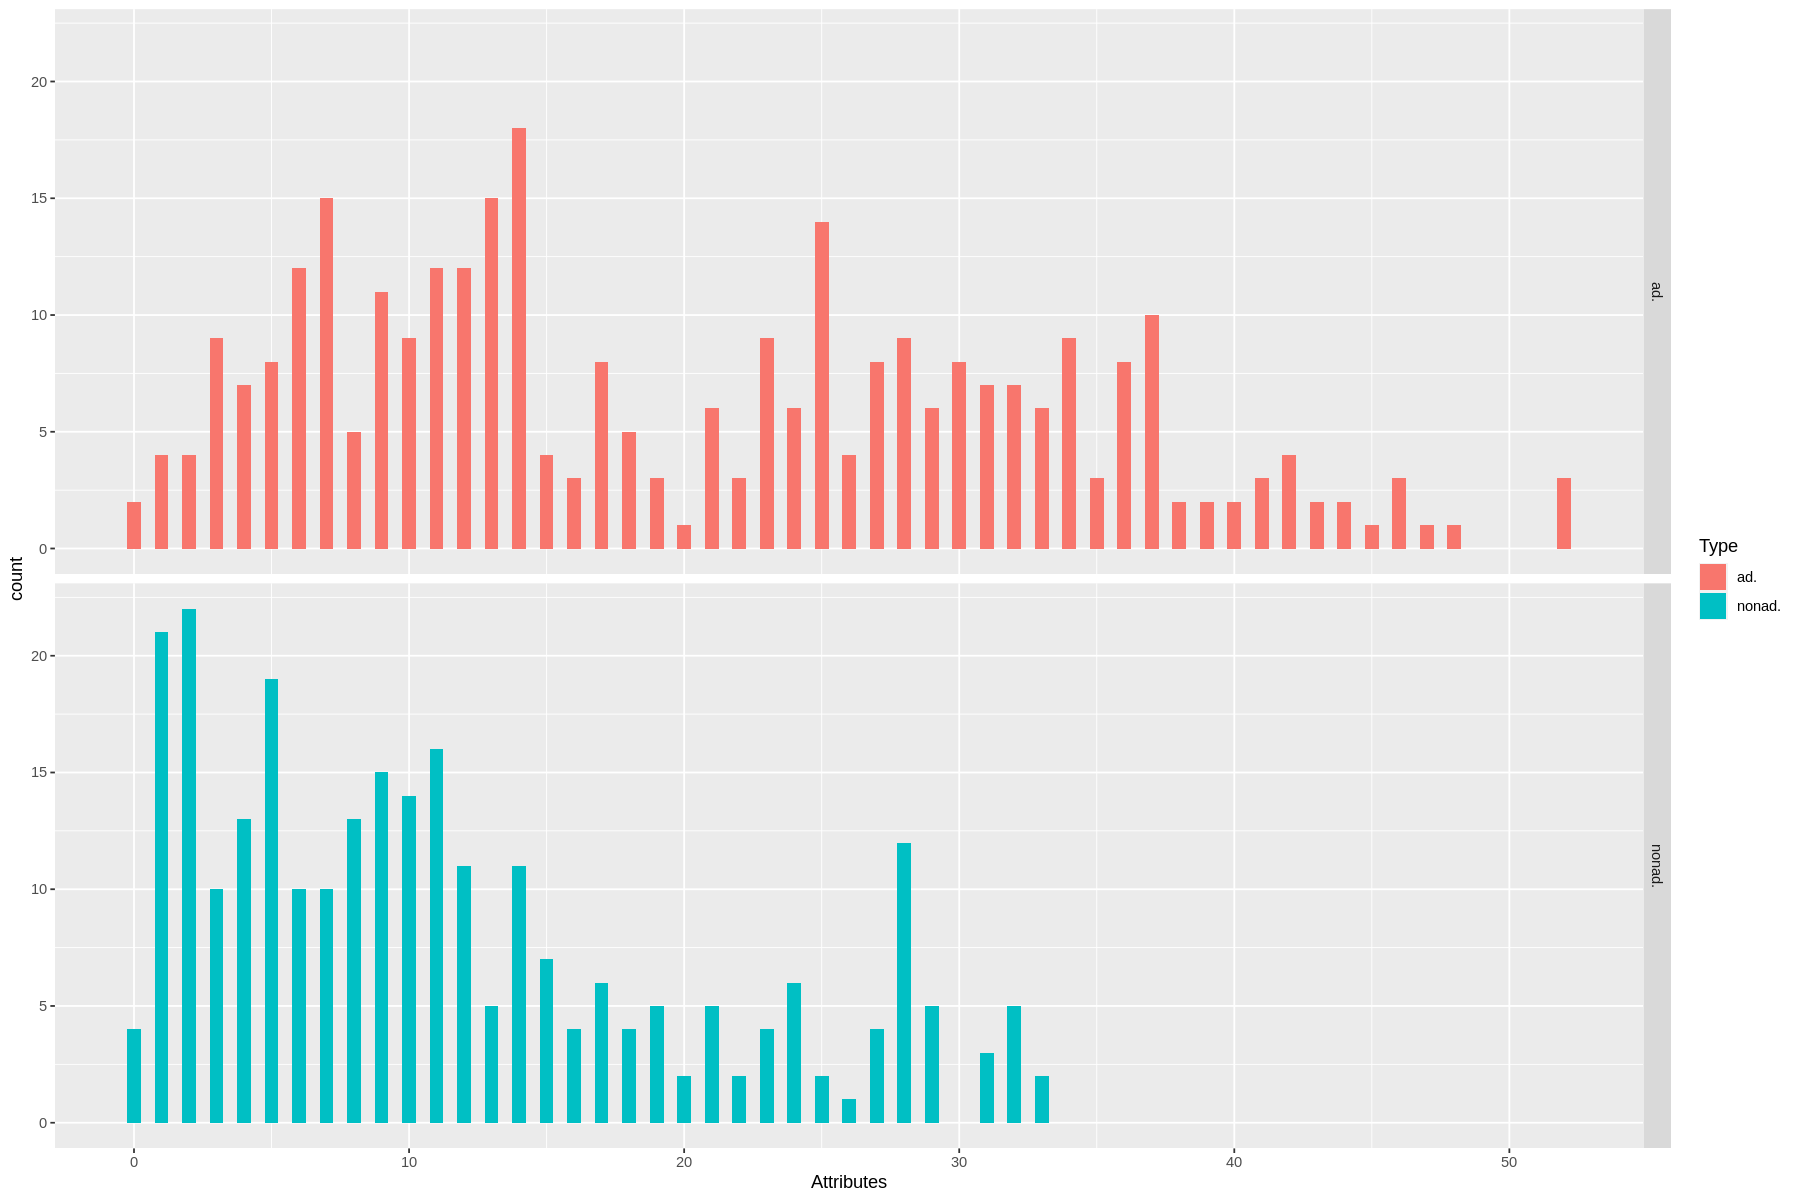

In [15]:
height_hist <- ggplot(ad_train, aes(x = Height, fill = Type)) +
               geom_histogram(binwidth = 5) +
               facet_grid(rows = vars(Type))
height_hist
width_hist <- ggplot(ad_train, aes(x = Width, fill = Type)) +
              geom_histogram(binwidth = 15) +
              facet_grid(rows = vars(Type))
width_hist
ratio_hist <- ggplot(ad_train, aes(x = Ratio, fill = Type)) +
              geom_histogram(binwidth = 0.4) +
              facet_grid(rows = vars(Type))
ratio_hist
attri_hist <- ggplot(ad_train, aes(x = Attributes, fill = Type)) +
              geom_histogram(binwidth = 0.5) +
              facet_grid(rows = vars(Type))
attri_hist

Next step is to scale all four predictors to have a mean of 0 and a standard deviation of 1.

In [16]:
ad_train_recipe <- recipe(Type ~ Height + Ratio + Attributes, data = ad_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())
ad_train_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Now we are all set to train our model with ad_train!

First lets perform a 10-fold cross validation to find the best value of K.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,accuracy,binary,0.8931687,10,0.01254501,Preprocessor1_Model04
3,accuracy,binary,0.8914446,10,0.01234698,Preprocessor1_Model03
1,accuracy,binary,0.8881979,10,0.01343413,Preprocessor1_Model01
2,accuracy,binary,0.8865030,10,0.01291410,Preprocessor1_Model02
5,accuracy,binary,0.8778833,10,0.01297064,Preprocessor1_Model05
6,accuracy,binary,0.8778833,10,0.01297064,Preprocessor1_Model06


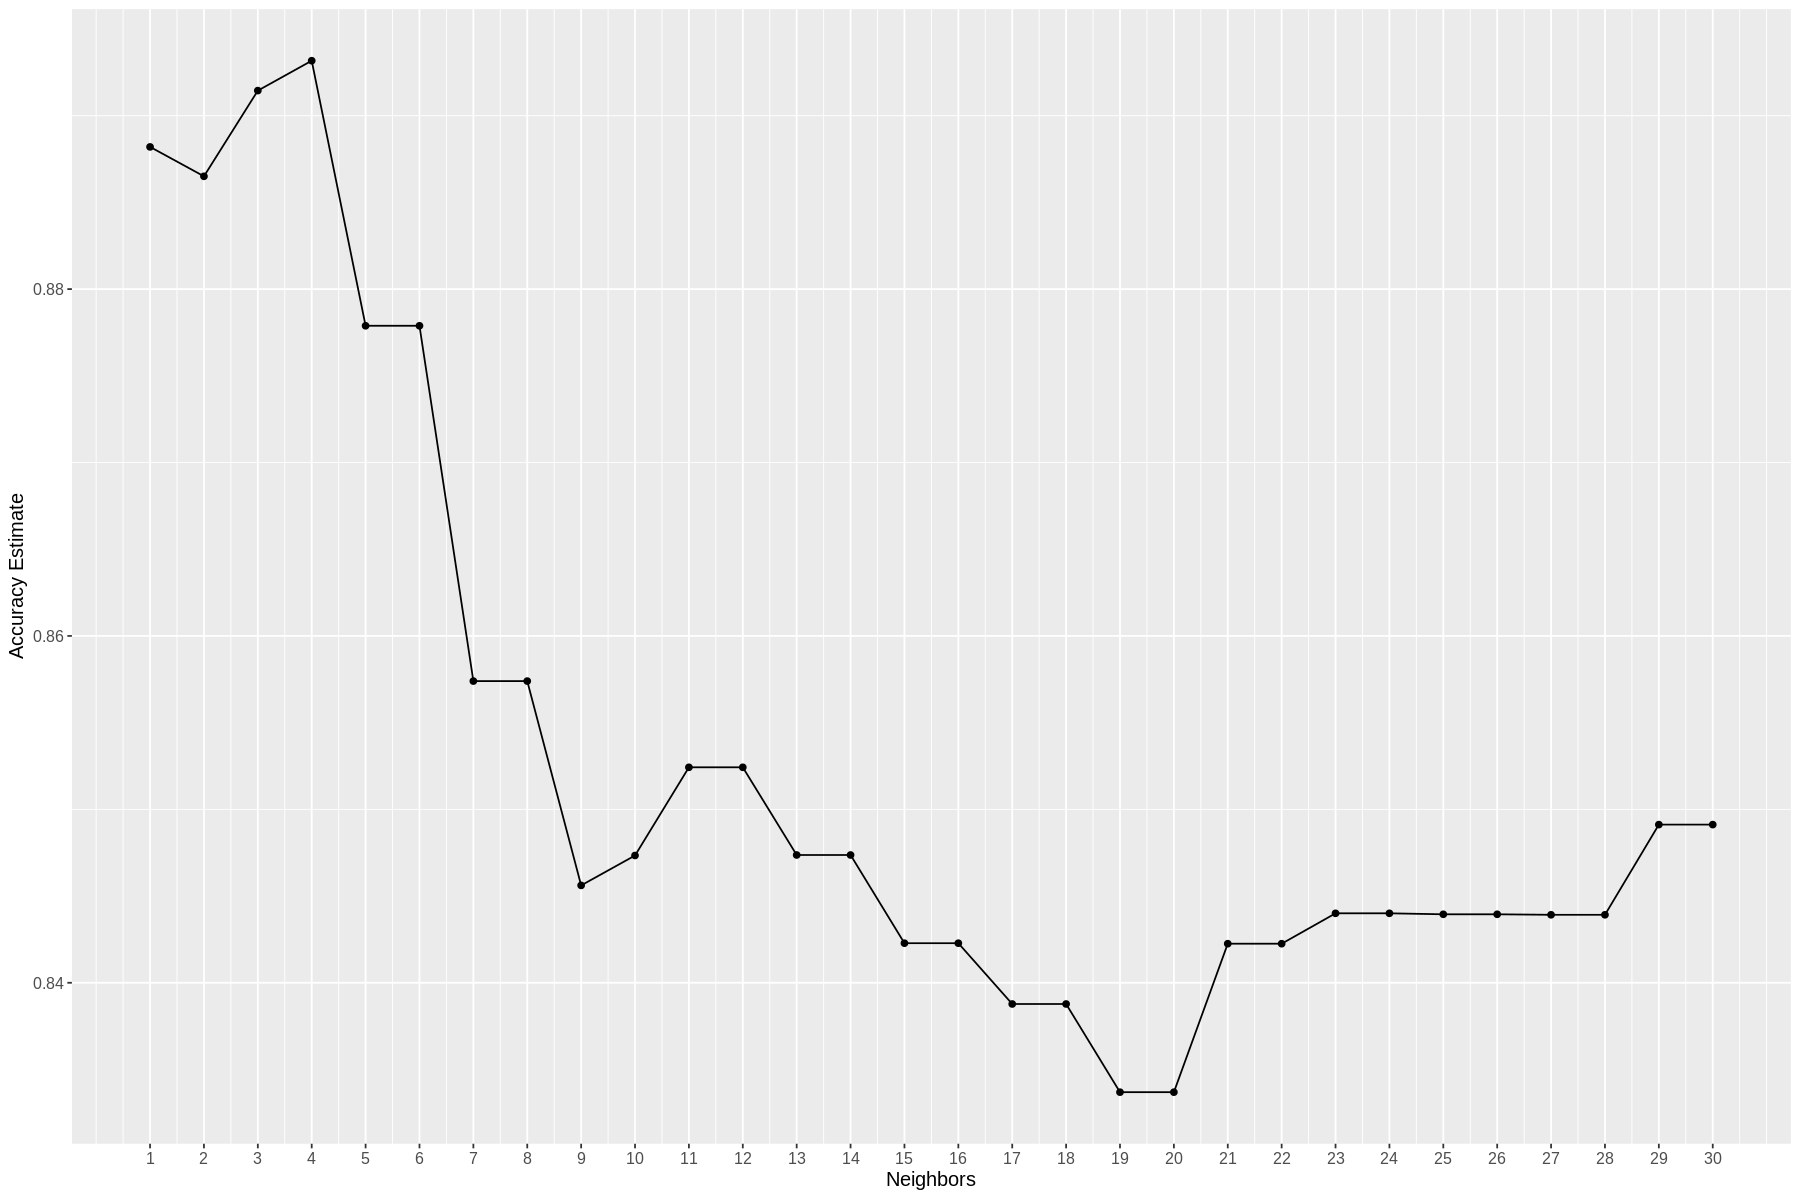

In [17]:
set.seed(7) #111

ad_vfold <- vfold_cv(ad_train, v = 10, strata = Type)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

ad_results <- workflow() |>
              add_recipe(ad_train_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = ad_vfold, grid = gridvals) |>
              collect_metrics()

kvalue <- ad_results |>
          filter(.metric == "accuracy") |>
          arrange(desc(mean))

maxkvalue <- head(kvalue)
maxkvalue

accuracy_vs_k <- ggplot(kvalue, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  scale_x_continuous(breaks = 1:30) + 
  theme(text = element_text(size = 12))
accuracy_vs_k

The results above show that the K with the most optimum accuracy is 4!

Now lets predict the image type using our model on our test data!

In [18]:
set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
            set_engine("kknn") |>
            set_mode("classification")

ad_fit <- workflow() |>
          add_recipe(ad_train_recipe) |>
          add_model(knn_spec) |>
          fit(data = ad_train)

predictions <- predict(ad_fit, ad_test) |>
               bind_cols(ad_test)
               
ad_predictions <- predictions |>
                  metrics(truth = Type, estimate = .pred_class) |>
                  filter(.metric == "accuracy") |>
                  select(.estimate) |>
                  pull()
ad_predictions

table <- predictions|>
         conf_mat(truth = Type, estimate = .pred_class)
table

[1] 0.95

          Truth
Prediction ad. nonad.
    ad.     52      3
    nonad.   2     43

Our model's accuracy on the test set is 95%

## Forward Analysis

In [19]:
set.seed(1)

random <- tibble(Random = (rexp(689, rate = 0.5)^2)) 
ad_w_random <- bind_cols(ad_cleaned, random)
ad_w_random

Height,Width,Ratio,Attributes,Type,Random
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
125,125,1.0000,14,ad.,2.28119840
57,468,8.2105,11,ad.,5.58511863
33,230,6.9696,22,ad.,0.08492180
60,468,7.8000,26,ad.,0.07817086
60,468,7.8000,24,ad.,0.76062339
60,468,7.8000,24,ad.,33.52337133
59,460,7.7966,27,ad.,6.04729137
60,234,3.9000,31,ad.,1.16503027
60,468,7.8000,23,ad.,3.66008548


In [20]:
set.seed(123)

names <- colnames(ad_w_random |> select(-Type))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
ad_fa_vfold <- vfold_cv(ad_w_random, v = 5, strata = Type)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Type", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        ad_fa_recipe <- recipe(as.formula(model_string), 
                                data = ad_w_random) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(ad_fa_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = ad_fa_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Type ~ Height,0.8098805
2,Type ~ Height+Ratio,0.8940654
3,Type ~ Height+Ratio+Attributes,0.9144081
4,Type ~ Height+Ratio+Attributes+Width,0.9100603
5,Type ~ Height+Ratio+Attributes+Width+Random,0.8766318


In [21]:
set.seed(123)

ad_new_recipe <- recipe(Type ~ Height + Ratio + Attributes, data = ad_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
            set_engine("kknn") |>
            set_mode("classification")

ad_fit <- workflow() |>
          add_recipe(ad_new_recipe) |>
          add_model(knn_spec) |>
          fit(data = ad_train)

predictions <- predict(ad_fit, ad_test) |>
               bind_cols(ad_test)
               
ad_predictions <- predictions |>
                  metrics(truth = Type, estimate = .pred_class) |>
                  filter(.metric == "accuracy") |>
                  select(.estimate) |>
                  pull()
ad_predictions

[1] 0.95

## Expected outcomes and significance:
We expect to find the ideal number of nearest neighbors (k) to use for the model, as well as the common traits for images that classify as advertisements. We also expect to find a classifier that is able to predict whether a test image is an internet advertisement or not. Lastly, we hope to launch a visualization that is able to represent the relationship between traits of the image (like height, width, ratio etc.) where background color indicates the decision of the classifier.

Advertisements have become a staple in the digital experiences of all types of consumers, and software that can detect ads has many applications. It can be used to compare advertisement counts between websites. Advertisers can use this software to see how saturated potential sponsor candidate’s sites are, and this software has an obvious, but perhaps unethical, application in ad-blockers.

This data analysis has the potential to return a plethora of questions to analyze in the future. How do different websites compare in advertisement counts? Does this affect the interactions generated with the ads? Is there a relationship between some of the predictors we used and the effectiveness of the advertisements? It also raises the important question: how can advertisers modify their advertisements to be less recognizable by software like this?

## Methods:
In our file we are looking at the variables: Height, Width, Ratio, Attributes and Type. We are inputting them into the recipe formula such that we use Height, Width, Ratio and Attributes to predict Type. As height, width, ratio and type weren’t initially listed as numeric variables, we first passed them through as.numeric() to make them numeric variables to aid in the data analysis. We then split the data set into a testing and training set and mutated type into a percentage, to aid in visualizing the split between an ad and non-ad type.

We are going to use a scatterplot to view the disparity between ad and non-ad types. This would also apply to see whether our test data matches the output of our training model. Furthermore, we would also like to try using pie charts to visualize the accuracy of our data, which includes the percentage of false positive, false negative, true positive, and true negative obtained from our results.